# Explainer: Single Egde & Target

## Library Import

In [18]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.explain import Explainer, GNNExplainer, ModelConfig
from torch_geometric.nn import GCNConv

if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

## Dataset

In [19]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True),
])

In [20]:
# Import dataset from PyTorch Geometric
dataset = Planetoid(root="dataset", name="Cora", transform=transform)

train_data, val_data, test_data = dataset[0]

<BarContainer object of 34 artists>

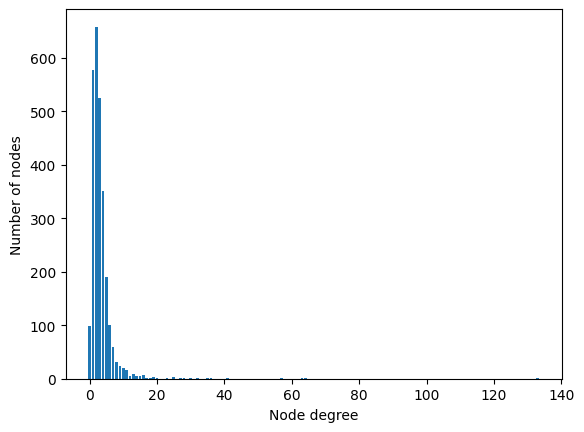

In [24]:
# Get list of degrees for each node
degrees = degree(train_data.edge_index[0]).cpu().numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots()
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

## GCN Model

In [4]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

    def decode(self, z, edge_label_index):
        src, dst = edge_label_index
        return (z[src] * z[dst]).sum(dim=-1)

    def forward(self, x, edge_index, edge_label_index):
        z = model.encode(x, edge_index)
        return model.decode(z, edge_label_index).view(-1)

In [5]:
model = GCN(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)


def train():
    model.train()
    optimizer.zero_grad()

    out = model(train_data.x, train_data.edge_index,
                train_data.edge_label_index)
    loss = F.binary_cross_entropy_with_logits(out, train_data.edge_label)
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model.eval()
    out = model(data.x, data.edge_index, data.edge_label_index).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())


for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        val_auc = test(val_data)
        test_auc = test(test_data)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
              f'Test: {test_auc:.4f}')

Epoch: 10, Loss: 0.6885, Val: 0.6796, Test: 0.6802
Epoch: 20, Loss: 0.6459, Val: 0.7326, Test: 0.7496
Epoch: 30, Loss: 0.5521, Val: 0.7462, Test: 0.7875
Epoch: 40, Loss: 0.4790, Val: 0.7926, Test: 0.7987
Epoch: 50, Loss: 0.4394, Val: 0.7692, Test: 0.7870
Epoch: 60, Loss: 0.4075, Val: 0.7488, Test: 0.7771
Epoch: 70, Loss: 0.3743, Val: 0.7435, Test: 0.7594
Epoch: 80, Loss: 0.3349, Val: 0.7469, Test: 0.7575
Epoch: 90, Loss: 0.2973, Val: 0.7521, Test: 0.7584
Epoch: 100, Loss: 0.2577, Val: 0.7546, Test: 0.7670
Epoch: 110, Loss: 0.2236, Val: 0.7443, Test: 0.7620
Epoch: 120, Loss: 0.1898, Val: 0.7371, Test: 0.7556
Epoch: 130, Loss: 0.1585, Val: 0.7318, Test: 0.7495
Epoch: 140, Loss: 0.1300, Val: 0.7253, Test: 0.7450
Epoch: 150, Loss: 0.1047, Val: 0.7249, Test: 0.7418
Epoch: 160, Loss: 0.0815, Val: 0.7196, Test: 0.7406
Epoch: 170, Loss: 0.0600, Val: 0.7138, Test: 0.7388
Epoch: 180, Loss: 0.0419, Val: 0.7097, Test: 0.7358
Epoch: 190, Loss: 0.0279, Val: 0.7051, Test: 0.7308
Epoch: 200, Loss: 0.0

## Explainer

In [6]:
model_config = ModelConfig(
    mode='binary_classification',
    task_level='edge',
    return_type='raw',
)

### Single Edge

In [7]:
# Explain model output for a single edge:
edge_label_index = val_data.edge_label_index[:, 0]

explainer = Explainer(
    model=model,
    explanation_type='model',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config,
)
explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    edge_label_index=edge_label_index,
)
print(f'Generated model explanations in {explanation.available_explanations}')

Generated model explanations in ['edge_mask', 'node_mask']


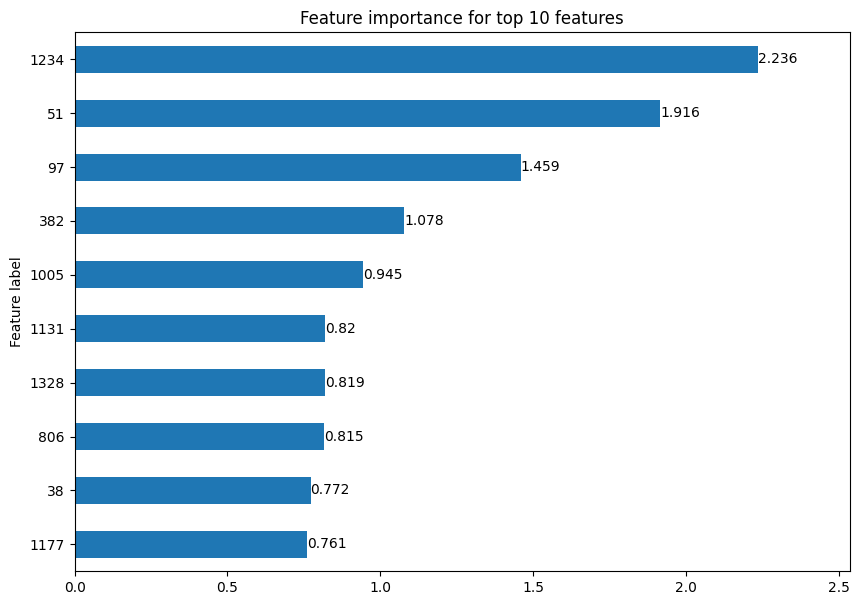

In [8]:
explanation.visualize_feature_importance(top_k=10)

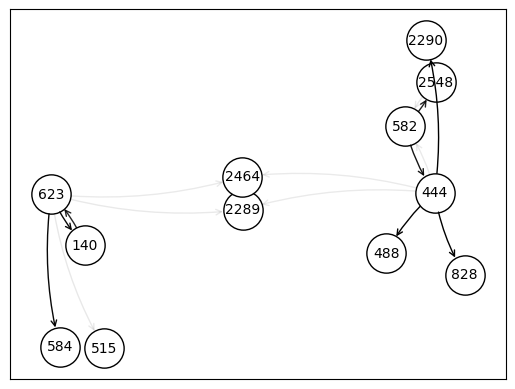

In [9]:
explanation.visualize_graph()

### Selected Target

In [10]:
# Explain a selected target (phenomenon) for a single edge:
edge_label_index = val_data.edge_label_index[:, 0]
target = val_data.edge_label[0].unsqueeze(dim=0).long()

explainer = Explainer(
    model=model,
    explanation_type='phenomenon',
    algorithm=GNNExplainer(epochs=200),
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=model_config,
)
explanation = explainer(
    x=train_data.x,
    edge_index=train_data.edge_index,
    target=target,
    edge_label_index=edge_label_index,
)
available_explanations = explanation.available_explanations
print(f'Generated phenomenon explanations in {available_explanations}')

Generated phenomenon explanations in ['edge_mask', 'node_mask']


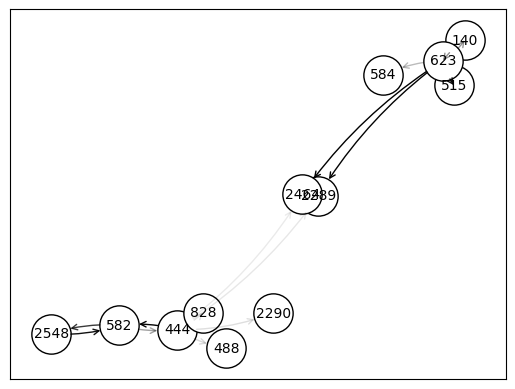

In [11]:
explanation.visualize_graph()